In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 25 12:37:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 119.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 141.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 57.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 135.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 118.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 63.

In [ ]:
from huggingface_hub import notebook_login
from datasets import Dataset, DatasetDict, Audio
import pandas as pd
import unicodedata
import re
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import Audio
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
import matplotlib.pyplot as plt

In [ ]:
notebook_login()

## Load Dataset

In [ ]:
dir_path = '/kaggle/input/voice-for-smart-home-vietnamese/dataset_custom/vi'

def load_common_voice_tsv(dir_path):
    # Load tsv
    train_df = pd.read_csv(f'{dir_path}/train.tsv', sep='\t')
    val_df = pd.read_csv(f'{dir_path}/dev.tsv', sep='\t')
    test_df = pd.read_csv(f'{dir_path}/test.tsv', sep='\t')

    for df in [train_df, val_df, test_df]:
        df.dropna(subset=["path", "sentence"], inplace=True)  # tránh lỗi thiếu dữ liệu

    train_df['audio'] = f'{dir_path}/clip/' + train_df['path']
    val_df['audio'] = f'{dir_path}/clip/' + val_df['path']
    test_df['audio'] = f'{dir_path}/clip/' + test_df['path']

    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_df),
        'val': Dataset.from_pandas(val_df),
        'test': Dataset.from_pandas(test_df)
    })

    return dataset

def normalize_text(batch):
    text = batch["sentence"]
    text = text.lower()
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r"[^\w\sàáảãạăắằẳẵặâấầẩẫậèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    batch["sentence"] = text
    return batch

def preprocess_common_voice():
    dataset = load_common_voice_tsv(dir_path)

    dataset = dataset.map(normalize_text)

    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

    return dataset


In [6]:
common_voice = preprocess_common_voice()
common_voice = common_voice.remove_columns(["accents", "client_id", "gender", "locale", "path", "url", "sentence_id"])

print(common_voice)

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'audio'],
        num_rows: 350
    })
    val: Dataset({
        features: ['sentence', 'audio'],
        num_rows: 150
    })
    test: Dataset({
        features: ['sentence', 'audio'],
        num_rows: 100
    })
})


## Prepare Feature Extractor, Tokenizer and Data

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
print(feature_extractor)

WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}



In [ ]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="vietnamese", task="transcribe")
print(tokenizer)

WhisperTokenizer(name_or_path='openai/whisper-small', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|he|>', '<|uk|>', '<|el|>', '<|ms|>', '<|cs|>', '<|ro|>', '<|da|>', '<|hu|>', '<|ta|>', '<|no|>', '<|th|>', '<|ur|>', '<|hr|>', '<|bg|>', '<|lt|>', '<|la|>', '<|mi|>', '<|ml|>', '<|cy|>', '<|sk|>', '<|te|>', '<|fa|>', '<|lv|>', '<|bn|>', '<|sr|>', '<|az|>', '<|sl|>', '<|kn|>', '<|et|>', '<|mk|>', '<|br|>', '<|eu|>', '<|is|>', '<|hy|>', '<|ne|>', '<|mn|>', '<|bs|>', '<|kk|>', '<|sq|>', '<|sw|>', '<|gl|>', '<|mr|>', '<|pa|>', '<|si

In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="vietnamese", task="transcribe")
print(processor)

WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-small', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<

### Prepare Data

In [ ]:
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [12]:
print(common_voice["train"][0])

{'sentence': 'hẹn giờ tắt quạt sau 15 phút', 'audio': {'path': '/kaggle/input/voice-for-smart-home-vietnamese/dataset_custom/vi/clip/00b3d0849955ffda0d60620e24abf62c.wav', 'array': array([ 5.49316406e-04,  3.05175781e-05,  0.00000000e+00, ...,
       -1.52587891e-04,  2.74658203e-04, -1.34277344e-03]), 'sampling_rate': 16000}}


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [14]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

Map (num_proc=2):   0%|          | 0/350 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

## Training and Evaluation

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
print(model)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [16]:
model.generation_config.language = "vietnamese"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

### Define a Data Collator

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        batch["attention_mask"] = torch.ones(batch["input_features"].shape[:-1], dtype=torch.long)

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [18]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

In [ ]:
metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer =  metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

### Define the Training Configuration

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-vi",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    lr_scheduler_type="linear",
    warmup_steps=500,
    num_train_epochs=10,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=32,
    report_to=["tensorboard"],
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

In [24]:
processor.save_pretrained(training_args.output_dir)

[]

### Training

In [25]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Epoch,Training Loss,Validation Loss,Wer
1,1.517400,1.590025,0.673882
2,1.200200,0.975631,0.435786
3,0.562200,0.350203,0.210678
4,0.156500,0.141665,0.077922
5,0.062600,0.076454,0.041847
6,0.035000,0.062630,0.041847
7,0.020900,0.055138,0.033189
8,0.012400,0.050500,0.028860
9,0.006700,0.057173,0.043290
10,0.007600,0.049363,0.033189


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation param

TrainOutput(global_step=220, training_loss=0.3581483755599369, metrics={'train_runtime': 1946.2117, 'train_samples_per_second': 1.798, 'train_steps_per_second': 0.113, 'total_flos': 1.01004890112e+18, 'train_loss': 0.3581483755599369, 'epoch': 10.0})

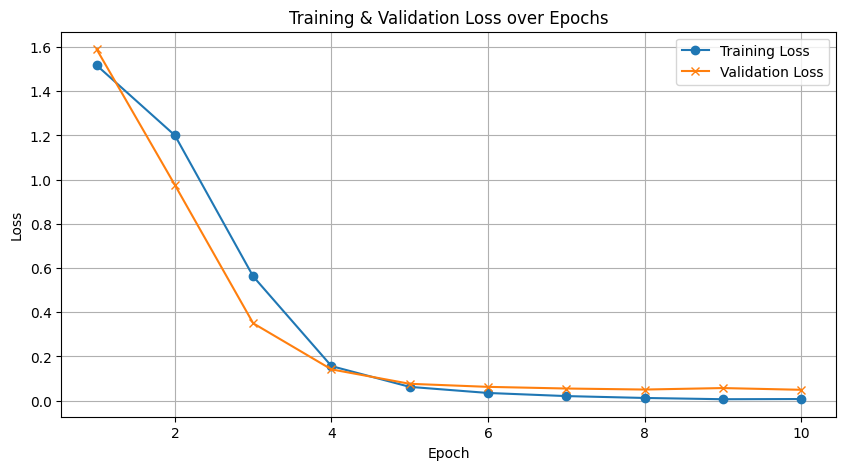

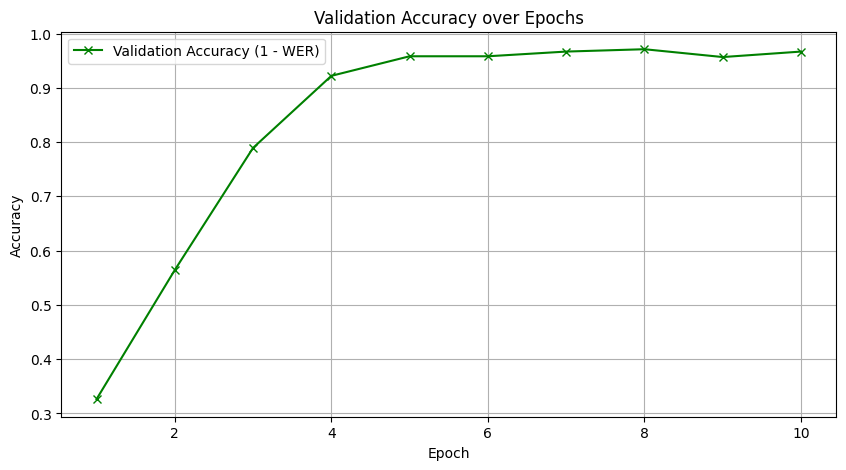

{'wer': 0.047619047619047616}
Test WER: 0.0476 (4.76%)
Test Accuracy (1 - WER): 0.9524 (95.24%)

▶️ Audio 2
🧠 Predict: mở cửa kia trời nóng
✅ Ground truth: mở cửa khi trời nóng

▶️ Audio 15
🧠 Predict: tự sắp ra ngoài
✅ Ground truth: tôi sắp ra ngoài

▶️ Audio 20
🧠 Predict: trời tối trời bật đèn giúp tôi
✅ Ground truth: trời tối rồi bật đèn giúp tôi

▶️ Audio 29
🧠 Predict: tôi ra khỏi nhà dồi
✅ Ground truth: tôi ra khỏi nhà rồi

▶️ Audio 32
🧠 Predict: dời tối rồi mật đèn giúp tôi
✅ Ground truth: trời tối rồi bật đèn giúp tôi

▶️ Audio 37
🧠 Predict: bật đèn kìa sáng yếu
✅ Ground truth: bật đèn khi ánh sáng yếu

▶️ Audio 38
🧠 Predict: tôi giờ về đến nhà
✅ Ground truth: tôi vừa về đến nhà

▶️ Audio 39
🧠 Predict: bật cửa
✅ Ground truth: mở cửa

▶️ Audio 43
🧠 Predict: bật đèn dạ buổi tối
✅ Ground truth: bật đèn vào buổi tối

▶️ Audio 44
🧠 Predict: cóc cửa tự động sau 10 phút
✅ Ground truth: khóa cửa tự động sau 10 phút

▶️ Audio 54
🧠 Predict: tôi giờ thức dậy
✅ Ground truth: tôi vừa thức dậy

In [ ]:
log_history = trainer.state.log_history
train_loss_steps = []
train_losses = []
eval_loss_steps = []
eval_losses = []
eval_wers = []

for log in log_history:
    if "loss" in log and "epoch" in log:  # training loss
        train_loss_steps.append(log["epoch"])
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_loss_steps.append(log["epoch"])
        eval_losses.append(log["eval_loss"])
    if "eval_wer" in log:
        eval_wers.append((log["epoch"], log["eval_wer"]))

# === Biểu đồ LOSS (Train + Validation) ===
plt.figure(figsize=(10, 5))
plt.plot(train_loss_steps, train_losses, label="Training Loss", marker="o")
plt.plot(eval_loss_steps, eval_losses, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# === Biểu đồ ACCURACY (Train + Validation) ===
if eval_wers:
    eval_epochs, eval_wer_values = zip(*eval_wers)
    eval_acc_values = [1 - wer for wer in eval_wer_values]

    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs, eval_acc_values, label="Validation Accuracy (1 - WER)", marker="x", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

# Dự đoán trên tập test
pred = trainer.predict(test_dataset=common_voice["test"])
metrics = compute_metrics(pred)
print(metrics)

# Hiển thị WER và Accuracy
print(f"Test WER: {metrics['wer']:.4f} ({metrics['wer'] * 100:.2f}%)")
print(f"Test Accuracy (1 - WER): {1 - metrics['wer']:.4f} ({(1 - metrics['wer']) * 100:.2f}%)")

Push model lên Hugging face

In [ ]:
kwargs = {
    # "dataset_tags": "mozilla-foundation/common_voice_17_0",
    "dataset": "Custom dataset for ASR",
    "dataset_args": "config: vi, split: test",
    "language": "vi",
    "model_name": "Whisper Small Vi - tuan8p",
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

In [28]:
trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/tuan8p/whisper-small-vi/commit/95277fbf919aa59f13d8f6fa59d429c3610b3342', commit_message='End of training', commit_description='', oid='95277fbf919aa59f13d8f6fa59d429c3610b3342', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tuan8p/whisper-small-vi', endpoint='https://huggingface.co', repo_type='model', repo_id='tuan8p/whisper-small-vi'), pr_revision=None, pr_num=None)